#### understanding retinal diseases through OCT
###### 1- Choroidal neovascularixation (CNV)
###### * neovascular membrane with subretinal fluid
###### 2- Diabetic Macular Edema (DME)
###### * retinal thickening with intraretinal fluid
###### 3- Drusen (early AMD)
###### * presence of multiple drusen deposits
###### 4- Normal retina
###### * preserved foveal contour, abssence of fluid or edema

## import requried libreries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle 
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping 
import os 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import cv2
from PIL import Image 
import glob
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam
import warnings 
warnings.filterwarnings('ignore')

2025-05-05 17:33:24.516940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746466404.721799      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746466404.786958      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path= '/kaggle/input/kermany2018/OCT2017 /train/'
val_path= '/kaggle/input/kermany2018/OCT2017 /val/'
test_path= '/kaggle/input/kermany2018/OCT2017 /test/'

print(os.listdir(train_path))
print(os.listdir(test_path))
print(os.listdir(val_path))

subfolders = os.listdir(train_path)

['DRUSEN', 'CNV', 'NORMAL', 'DME']
['DRUSEN', 'CNV', 'NORMAL', 'DME']
['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [3]:
# number of images in categories
for path in [train_path, test_path, val_path]:
    print(f"Counting Images in {train_path.split('/')[-1]} folder")
          
    for folder in subfolders:
        folder_path = os.path.join(path, folder)
        count = sum(1 for entry in os.scandir(folder_path))
        print(f"Number of images in {folder}: {count}")
    print('-'*30)

Counting Images in  folder
Number of images in DRUSEN: 8616
Number of images in CNV: 37205
Number of images in NORMAL: 26315
Number of images in DME: 11348
------------------------------
Counting Images in  folder
Number of images in DRUSEN: 242
Number of images in CNV: 242
Number of images in NORMAL: 242
Number of images in DME: 242
------------------------------
Counting Images in  folder
Number of images in DRUSEN: 8
Number of images in CNV: 8
Number of images in NORMAL: 8
Number of images in DME: 8
------------------------------


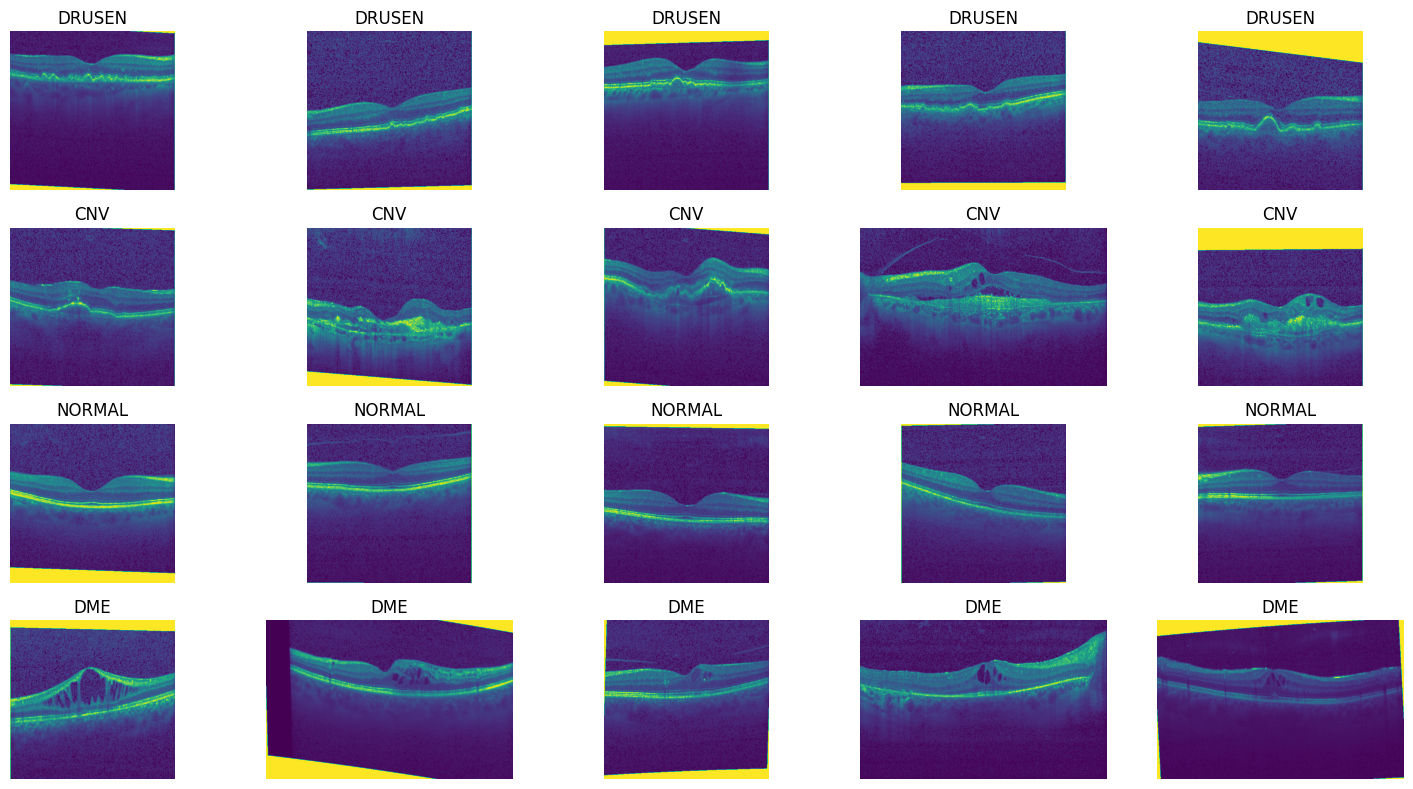

In [4]:
# visualization
fig, axes = plt.subplots(4, 5, figsize=(15, 8))
axes = axes.flatten()
axes_counter = 0

# Loop through each subfolder
for subfolder in subfolders:
    # extract the files in subfolder
    files = os.listdir(os.path.join(test_path, subfolder))

    # Select any 5 files from the subfolder
    selected_files = files[25:30]

    # Loop through the selected files and plot them in the corresponding subplot
    for i, image in enumerate(selected_files):
        i += axes_counter
        image_path = os.path.join(test_path, subfolder, image)
        img = plt.imread(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(subfolder)

    axes_counter +=5

plt.tight_layout()
plt.show()

In [5]:
# sizes of the images
# cv2 library is faster than matplotlib imread() method

x1 = []
y1 = []

# Loop through each subfolder
for subfolder in subfolders:
    # extract the files in subfolder
    files = os.listdir(os.path.join(test_path, subfolder))

    for file in files:
        image_path = os.path.join(test_path, subfolder, file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        d1, d2 = img.shape
        x1.append(d1)
        y1.append(d2)

print(np.mean(x1), np.mean(y1))

print(x1[:20])
print(y1[:20])

496.0 571.7685950413223
[496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496]
[512, 512, 512, 512, 768, 768, 512, 512, 512, 512, 512, 768, 512, 768, 512, 512, 512, 512, 512, 512]


In [6]:
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# EDA: Count number of images per category in each set
def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        category_count[category] = len(os.listdir(category_path))
    return category_count

# Get image distribution for train, validation, and test sets
train_distribution = count_images_in_directory(train_path)
test_distribution = count_images_in_directory(test_path)
val_distribution = count_images_in_directory(val_path)

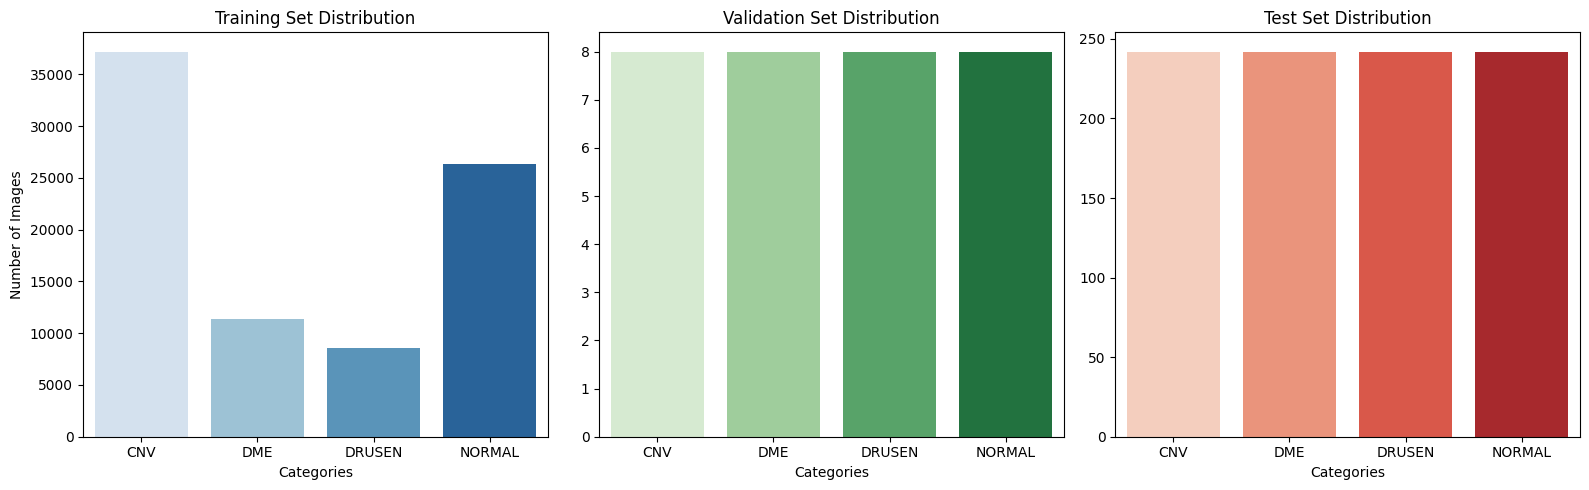

In [7]:
# Plot the distribution of images across categories for train, validation, and test sets
def plot_class_distribution():
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1, 3, 1)
    sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette="Blues")
    plt.title("Training Set Distribution")
    plt.xlabel("Categories")
    plt.ylabel("Number of Images")
    
    plt.subplot(1, 3, 2)
    sns.barplot(x=list(val_distribution.keys()), y=list(val_distribution.values()), palette="Greens")
    plt.title("Validation Set Distribution")
    plt.xlabel("Categories")
    
    plt.subplot(1, 3, 3)
    sns.barplot(x=list(test_distribution.keys()), y=list(test_distribution.values()), palette="Reds")
    plt.title("Test Set Distribution")
    plt.xlabel("Categories")
    
    plt.tight_layout()
    plt.show()

# Display class distribution plots
plot_class_distribution()

#### image processing


In [8]:
# Image preprocessing using ImageDataGenerator
img_size = (128, 128)
batch_size = 32

In [9]:
# Augmentation and rescaling for training set
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Data Generators
train_generator = train_datagen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [11]:
# training_set = image_dataset_from_directory(                 
#     '/kaggle/input/kermany2018/OCT2017 /train',                    
#     labels = 'inferred',
#     label_mode = 'categorical',
#     class_names = None,
#     color_mode = 'rgb',                         
#     batch_size = 32,
#     image_size = (224,224),
#     shuffle = True,
#     seed = None, 
#     validation_split = None,
#     subset = None,
#     interpolation = 'bilinear',
#     follow_links = False,
#     crop_to_aspect_ratio = False
# )

In [12]:
# test_set = image_dataset_from_directory(                 
#     '/kaggle/input/kermany2018/OCT2017 /test',                    
#     labels = 'inferred',
#     label_mode = 'categorical',
#     class_names = None,
#     color_mode = 'rgb',                         
#     batch_size = 32,
#     image_size = (224,224),
#     shuffle = True,
#     seed = None, 
#     validation_split = None,
#     subset = None,
#     interpolation = 'bilinear',
#     follow_links = False,
#     crop_to_aspect_ratio = False
# )


In [13]:
# val_set = image_dataset_from_directory(                 
#     '/kaggle/input/kermany2018/OCT2017 /val',                    
#     labels = 'inferred',
#     label_mode = 'categorical',
#     class_names = None,
#     color_mode = 'rgb',                         
#     batch_size = 32,
#     image_size = (224,224),
#     shuffle = True,
#     seed = None, 
#     validation_split = None,
#     subset = None,
#     interpolation = 'bilinear',
#     follow_links = False,
#     crop_to_aspect_ratio = False
# )

In [14]:
early_stopping = EarlyStopping(
    monitor = 'val_accuray',
    patience = 3,
    mode = 'max',
    restore_best_weights = True
)

# CNN model

In [15]:
cnnmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  
])

cnnmodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

I0000 00:00:1746466517.915778      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [16]:
cnnmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = cnnmodel.fit(train_generator, validation_data=val_generator, epochs=15, callbacks = [early_stopping])

Epoch 1/15


I0000 00:00:1746466526.148729     113 service.cc:148] XLA service 0x78a840004af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746466526.149590     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746466526.458702     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2609 ━━━━━━━━━━━━━━━━━━━━ 6:42:37 9s/step - accuracy: 0.1875 - loss: 1.4016

I0000 00:00:1746466529.293156     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1170s 445ms/step - accuracy: 0.6149 - loss: 0.9736 - val_accuracy: 0.5938 - val_loss: 1.0336
Epoch 2/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 583s 223ms/step - accuracy: 0.7672 - loss: 0.6297 - val_accuracy: 0.9062 - val_loss: 0.3767
Epoch 3/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 570s 218ms/step - accuracy: 0.8449 - loss: 0.4394 - val_accuracy: 0.9375 - val_loss: 0.1319
Epoch 4/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 568s 217ms/step - accuracy: 0.8763 - loss: 0.3620 - val_accuracy: 0.9375 - val_loss: 0.1667
Epoch 5/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 560s 214ms/step - accuracy: 0.8886 - loss: 0.3282 - val_accuracy: 1.0000 - val_loss: 0.0463
Epoch 6/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 560s 214ms/step - accuracy: 0.8998 - loss: 0.3026 - val_accuracy: 0.9688 - val_loss: 0.0898
Epoch 7/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 566s 216ms/step - accuracy: 0.9005 - loss: 0.2963 - val_accuracy: 0.9375 - val_loss: 0.1151
Epoch 8/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 567s 217ms/step - accuracy: 0.

In [19]:
# Evaluate model on test set
test_loss, test_acc = cnnmodel.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9606 - loss: 0.1629
Test Accuracy: 95.87%


In [20]:
# Predicting on the test set
test_predictions = cnnmodel.predict(test_generator)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = test_generator.classes

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


In [21]:
# Classification report
class_report = classification_report(true_labels, test_predictions_labels, target_names=categories)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         CNV       0.91      1.00      0.95       242
         DME       1.00      0.85      0.92       242
      DRUSEN       1.00      0.99      0.99       242
      NORMAL       0.95      1.00      0.97       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


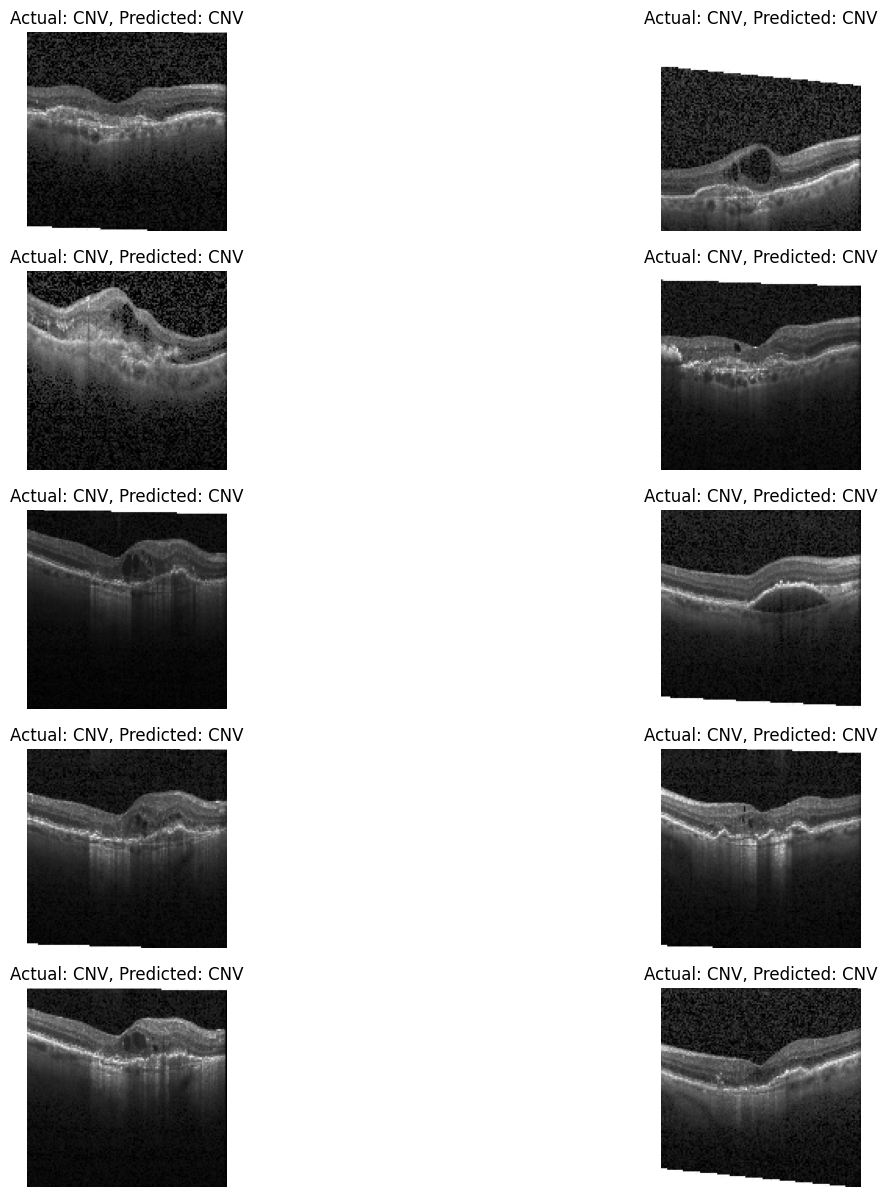

In [23]:
# Display 10 sample predictions with actual and predicted labels
def plot_sample_predictions(test_generator, num_samples=10):
    test_generator.reset()
    sample_images, sample_labels = next(test_generator)
    predictions = cnnmodel.predict(sample_images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 2, i+1)
        plt.imshow(sample_images[i])
        plt.title(f"Actual: {categories[np.argmax(sample_labels[i])]}, Predicted: {categories[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

# Show 10 samples with predictions
plot_sample_predictions(test_generator)

In [24]:
cnnmodel.save('/kaggle/working/cnn_model.h5')

# MobileNetV3 model

In [27]:
mobnet = tf.keras.applications.MobileNetV3Large(
    input_shape = (128,128, 3),
    alpha = 1.0,
    minimalistic = False,
    include_top = True,
    weights = 'imagenet',
    input_tensor = None,
    classes = 1000,
    pooling = None,
    dropout_rate = 0.2,
    classifier_activation = 'softmax',
    include_preprocessing = True
)

22661472/22661472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
model = tf.keras.models.Sequential()

In [29]:
model.add(tf.keras.Input(shape = (128,128,3)))

In [30]:
model.add(mobnet)

In [31]:
model.add(tf.keras.layers.Dense(4, activation = 'softmax'))

In [33]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 1000)                │       5,507,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           4,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,511,436 (21.02 MB)

 Trainable params: 5,487,036 (20.93 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [35]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks = [early_stopping])


Epoch 1/15


E0000 00:00:1746476010.951354     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476011.134129     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476011.483353     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476011.666801     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476011.933626     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1621/2609 ━━━━━━━━━━━━━━━━━━━━ 3:48 232ms/step - accuracy: 0.6839 - loss: 1.2798

E0000 00:00:1746476408.991239     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476409.175417     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476409.536125     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476409.721890     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746476409.989409     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

2609/2609 ━━━━━━━━━━━━━━━━━━━━ 694s 242ms/step - accuracy: 0.7045 - loss: 1.2422 - val_accuracy: 0.3125 - val_loss: 1.4077
Epoch 2/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 585s 224ms/step - accuracy: 0.8259 - loss: 0.9364 - val_accuracy: 0.7188 - val_loss: 0.9984
Epoch 3/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 586s 224ms/step - accuracy: 0.8820 - loss: 0.7336 - val_accuracy: 0.9062 - val_loss: 0.7780
Epoch 4/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 580s 222ms/step - accuracy: 0.9040 - loss: 0.5916 - val_accuracy: 0.3750 - val_loss: 1.7280
Epoch 5/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 570s 218ms/step - accuracy: 0.9138 - loss: 0.4848 - val_accuracy: 1.0000 - val_loss: 0.3737
Epoch 6/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 564s 216ms/step - accuracy: 0.9215 - loss: 0.4056 - val_accuracy: 0.2500 - val_loss: 2.4852
Epoch 7/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 557s 213ms/step - accuracy: 0.9298 - loss: 0.3401 - val_accuracy: 0.2500 - val_loss: 2.7486
Epoch 8/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 558s 213ms/step - accuracy: 0.9

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


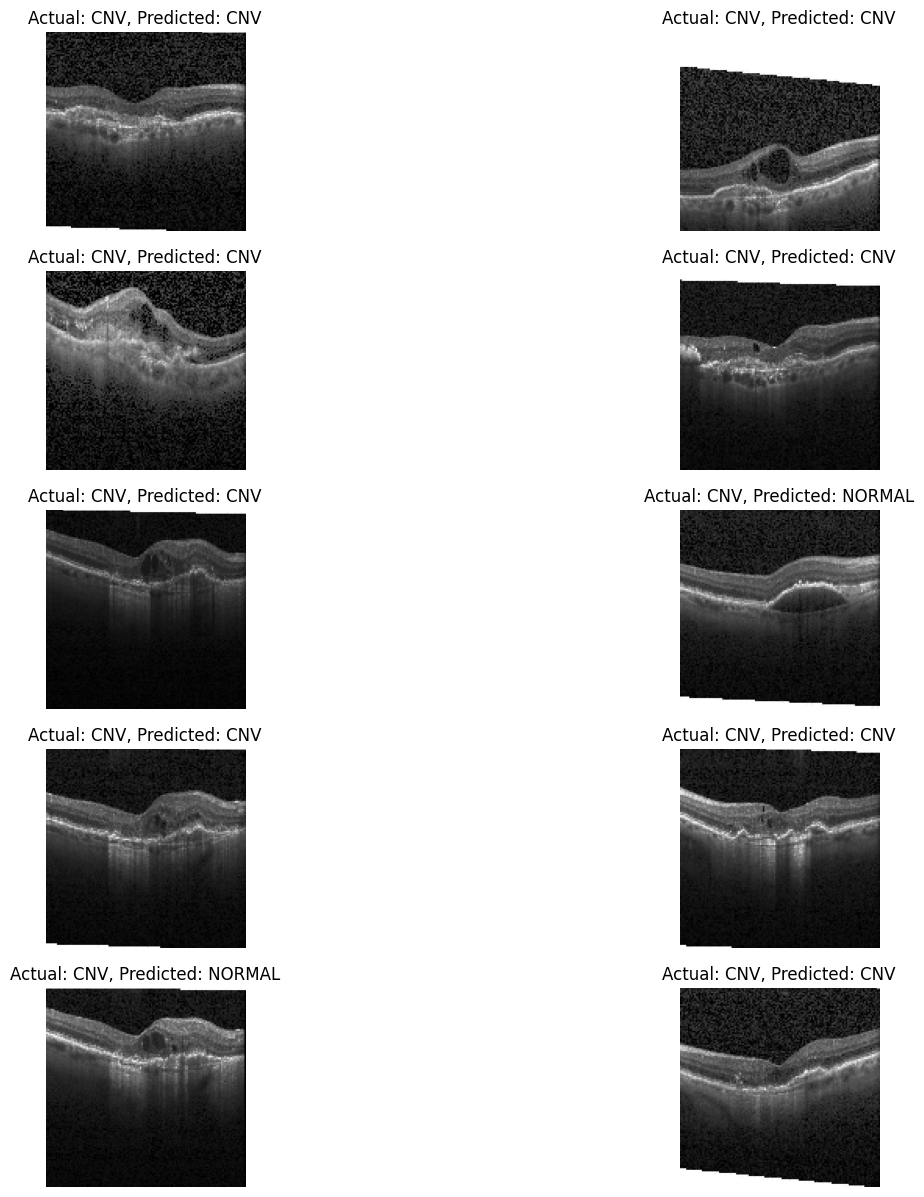

In [36]:
# Display 10 sample predictions with actual and predicted labels
def plot_sample_predictions(test_generator, num_samples=10):
    test_generator.reset()
    sample_images, sample_labels = next(test_generator)
    predictions = cnnmodel.predict(sample_images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 2, i+1)
        plt.imshow(sample_images[i])
        plt.title(f"Actual: {categories[np.argmax(sample_labels[i])]}, Predicted: {categories[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

# Show 10 samples with predictions
plot_sample_predictions(test_generator)

In [37]:
model.save('/kaggle/working/mobnet_model.h5')

In [38]:
model.save('/kaggle/working/mobnet_model.keras')

In [41]:
with open('/kaggle/working/mobnet_model.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [42]:
with open('/kaggle/working/mobnet_model.pkl', 'rb') as f:
    load_history = pickle.load(f)
load_history    

{'accuracy': [0.740980327129364,
  0.8361243009567261,
  0.8910329937934875,
  0.9053112268447876,
  0.9156724810600281,
  0.923482358455658,
  0.9306094646453857,
  0.9349935054779053,
  0.9391859769821167,
  0.9424799680709839,
  0.9455344676971436,
  0.9475348591804504,
  0.9498347043991089,
  0.9516793489456177,
  0.953548014163971],
 'loss': [1.149342656135559,
  0.8803473711013794,
  0.6986396908760071,
  0.565563440322876,
  0.4646185338497162,
  0.3871137797832489,
  0.32762598991394043,
  0.28469765186309814,
  0.25123897194862366,
  0.22940956056118011,
  0.20806589722633362,
  0.1957993358373642,
  0.1825740933418274,
  0.1724068820476532,
  0.16540196537971497],
 'val_accuracy': [0.3125,
  0.71875,
  0.90625,
  0.375,
  1.0,
  0.25,
  0.25,
  0.9375,
  1.0,
  0.25,
  0.96875,
  0.25,
  0.9375,
  0.25,
  0.53125],
 'val_loss': [1.407691478729248,
  0.9983803033828735,
  0.778025209903717,
  1.7279635667800903,
  0.37369710206985474,
  2.4852349758148193,
  2.7486257553100586

In [43]:
epochs = [i for i in range[3,8]]
plt.plot(epochs,load_history['loss'], color = 'red', label = 'Training Loss')
plt.plot(epochs, load_history['val_loss'], color = 'blue', label = 'Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('visualization of Loss Result')
plt.legend()
plt.show()

TypeError: type 'range' is not subscriptable

In [44]:
test_loss, test_acc, f1_score = model.evaluate(val_set)

NameError: name 'val_set' is not defined

In [45]:
test_loss

0.16893024742603302

In [46]:
test_acc

0.9586777091026306

In [47]:
f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [56]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


## VGG16 model 

In [59]:
from keras import models
from keras import layers
# from sklearn.utils.class_weight import compute_class_weigh

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape= (128,128, 3)
)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Lets Create our model by adding custom layers on top of VGG16
vmodel = models.Sequential()
vmodel.add(base_model)
vmodel.add(layers.Flatten())
vmodel.add(layers.Dense(256, activation='relu'))
vmodel.add(layers.Dropout(0.50))
vmodel.add(layers.Dense(4, activation='softmax'))

# Compile the model
vmodel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Deal with class imbalances
# class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(train_image_generator.classes), y= train_image_generator.classes)
# class_weight_dict = dict(enumerate(class_weights))


In [60]:
vmodel.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,813,124 (64.14 MB)

 Trainable params: 2,098,436 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [62]:
history = vmodel.fit(train_generator, validation_data=val_generator, epochs=15, callbacks = [early_stopping])

Epoch 1/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 604s 228ms/step - accuracy: 0.6684 - loss: 0.8876 - val_accuracy: 0.6875 - val_loss: 0.5156
Epoch 2/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 512s 196ms/step - accuracy: 0.7385 - loss: 0.7040 - val_accuracy: 0.7500 - val_loss: 0.4648
Epoch 3/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 513s 196ms/step - accuracy: 0.7487 - loss: 0.6769 - val_accuracy: 0.8125 - val_loss: 0.3562
Epoch 4/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 510s 195ms/step - accuracy: 0.7614 - loss: 0.6423 - val_accuracy: 0.7500 - val_loss: 0.3918
Epoch 5/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 523s 200ms/step - accuracy: 0.7668 - loss: 0.6329 - val_accuracy: 0.7500 - val_loss: 0.3078
Epoch 6/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 527s 202ms/step - accuracy: 0.7695 - loss: 0.6219 - val_accuracy: 0.7812 - val_loss: 0.4058
Epoch 7/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 508s 194ms/step - accuracy: 0.7743 - loss: 0.6125 - val_accuracy: 0.8125 - val_loss: 0.3795
Epoch 8/15
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 508s 194ms/step - ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


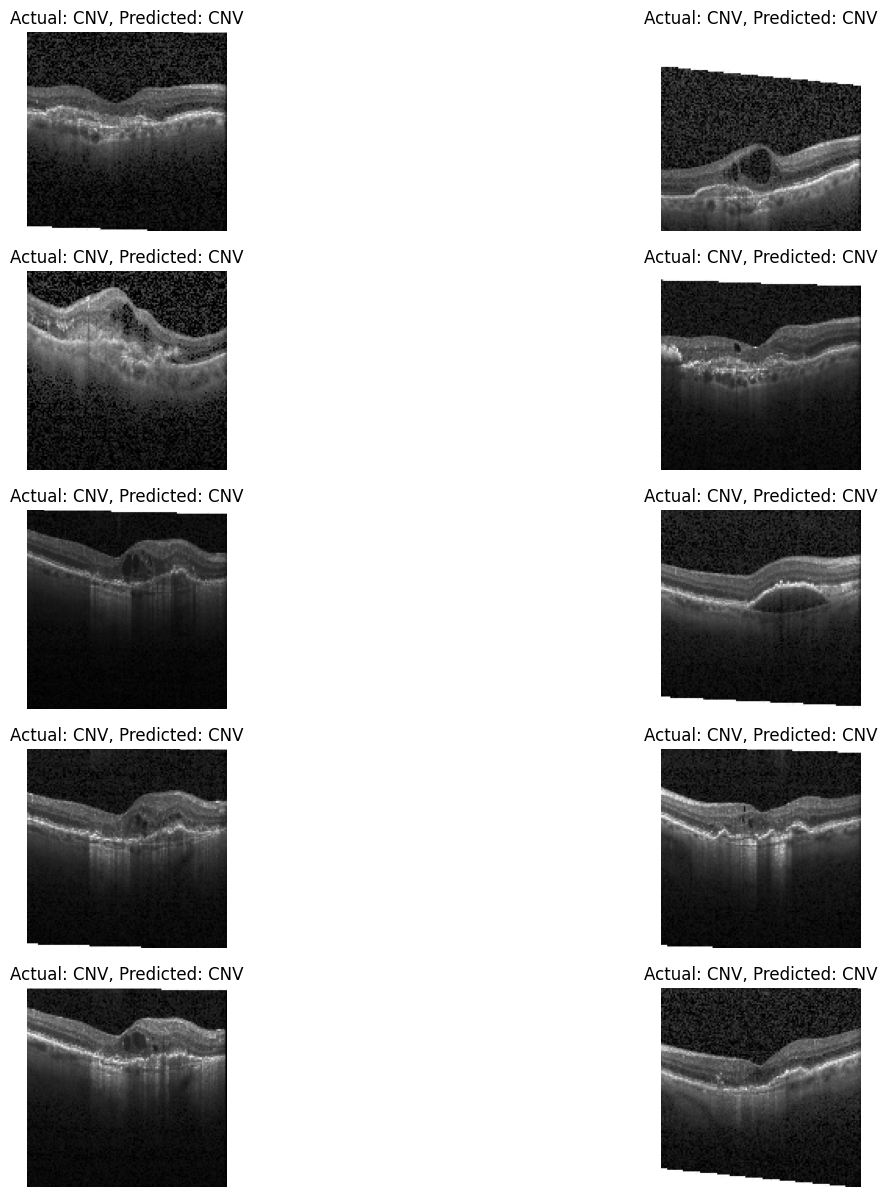

In [63]:
# Display 10 sample predictions with actual and predicted labels
def plot_sample_predictions(test_generator, num_samples=10):
    test_generator.reset()
    sample_images, sample_labels = next(test_generator)
    predictions = vmodel.predict(sample_images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 2, i+1)
        plt.imshow(sample_images[i])
        plt.title(f"Actual: {categories[np.argmax(sample_labels[i])]}, Predicted: {categories[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

# Show 10 samples with predictions
plot_sample_predictions(test_generator)

In [64]:
# Save the model
vmodel.save('/kaggle/working/vgg16_model.h5')

# Model prediction 

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
# import numpy as np
# import os

In [ ]:
# model = tf.keras.models.load_model('/kaggle/input/mobnet/keras/default/1/mobnet_model.h5', compile = False)

In [ ]:
# img_path = '/kaggle/input/kermany2018/OCT2017 /val/DME/DME-9583225-2.jpeg'
# img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
# x= tf.keras.utils.img_to_array(img)
# x = np.expand_dims(x, axis = 0)
# x = preprocess_input(x)

In [ ]:
# preds = model.predict(x)

In [ ]:
# preds

In [ ]:
# class_name = os.listdir('/kaggle/input/kermany2018/OCT2017 /train')
# class_name

In [ ]:
# result_index = np.argmax(preds)
# class_name[result_index]